In [10]:
!pip install tensorflow opencv-python matplotlib
!pip list

import tensorflow as tf
import os

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')



Package                      Version
---------------------------- ---------
absl-py                      2.1.0
annotated-types              0.6.0
anyio                        4.4.0
asttokens                    2.4.1
astunparse                   1.6.3
blis                         0.7.11
CacheControl                 0.14.0
cachetools                   5.3.3
catalogue                    2.0.10
certifi                      2024.2.2
cffi                         1.16.0
charset-normalizer           3.3.2
click                        8.1.7
cloudpathlib                 0.16.0
colorama                     0.4.6
comm                         0.2.2
confection                   0.1.4
contourpy                    1.2.1
cryptography                 42.0.8
cycler                       0.12.1
cymem                        2.0.8
debugpy                      1.8.1
decorator                    5.1.1
dnspython                    2.6.1
email_validator              2.2.0
en-core-web-sm               3.7.1
exce

[]

In [11]:
# Remove Random Image
import cv2
import imghdr

data_dir = 'Dataset_DS'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)



Found 2297 files belonging to 3 classes.


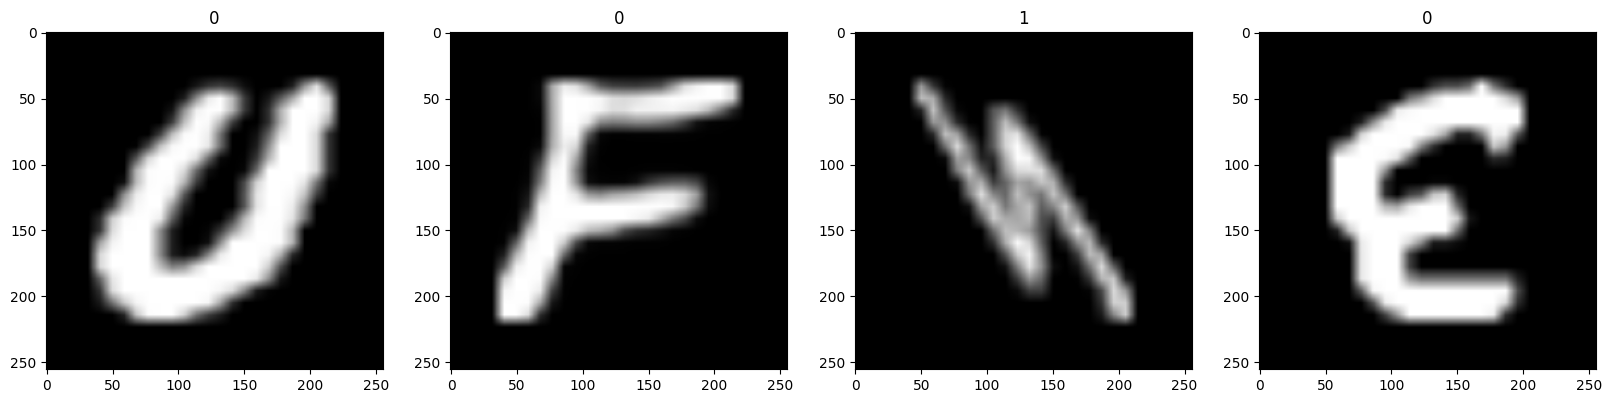

In [12]:
# Load Data
import numpy as np
from matplotlib import pyplot as plt

data = tf.keras.utils.image_dataset_from_directory('Dataset_DS')

data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Scale Data
data = data.map(lambda x, y: (x / 255, y))
data.as_numpy_iterator().next()

# Split Data
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)



In [13]:
# Build Dyslexia Scanner Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential()
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])



Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.7371 - loss: 0.5247 - val_accuracy: 0.8438 - val_loss: 0.3578
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.8673 - loss: 0.3133 - val_accuracy: 0.8884 - val_loss: 0.2839
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.9119 - loss: 0.2310 - val_accuracy: 0.9085 - val_loss: 0.2190
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.9232 - loss: 0.1735 - val_accuracy: 0.9286 - val_loss: 0.2219
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.9407 - loss: 0.0895 - val_accuracy: 0.9018 - val_loss: 0.2215
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.9386 - loss: 0.0190 - val_accuracy: 0.9107 - val_loss: 0.2483
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.9610 - loss: -0.3798 - val_accuracy: 0.9397 - val_loss: 0.1587
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 0.9754 - loss: -0.1963 - val_accuracy:

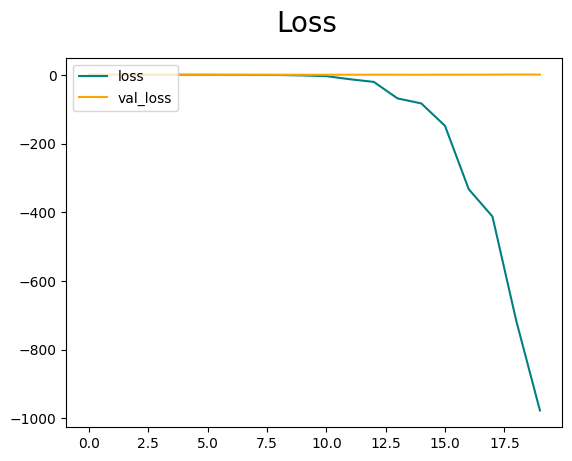

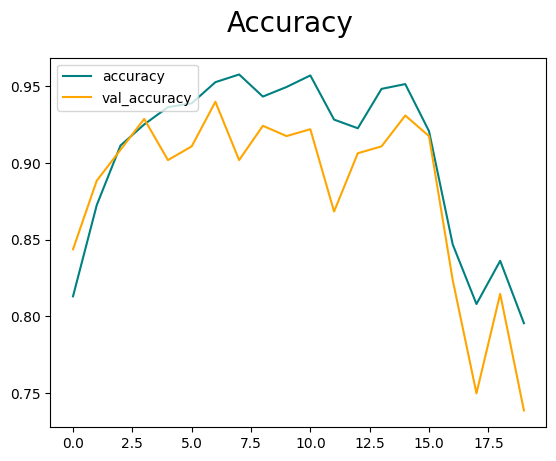

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Precision: 0.7402597665786743, Recall: 0.6195651888847351, Accuracy: 0.7544642686843872


In [15]:
# Plot Performance
# Loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')



In [16]:
# Save Model
model.save(os.path.join('models', 'dyslexia_scanner_new.keras'))

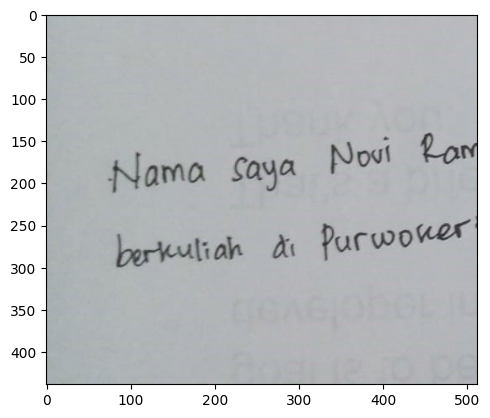

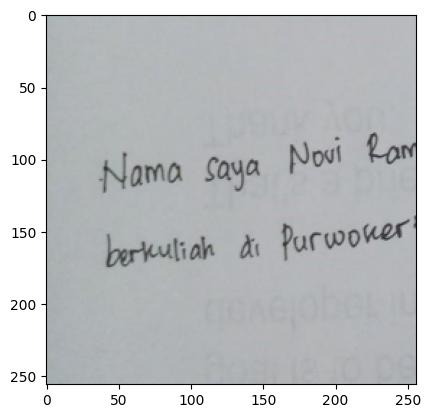

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
[[0.29422235]]
congratulations, you are normal


In [17]:
# Test Model
from tensorflow.keras.models import load_model
import tensorflow as tf
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

new_model = load_model(os.path.join('models', 'dyslexia_scanner_new.keras'))

import cv2
img = cv2.imread('Dataset_DS/Test/test_dyslexia_normal.jpg')
plt.imshow(img)
plt.show()

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = new_model.predict(np.expand_dims(resize/255, 0))

print(yhat)

if yhat > 0.5:
    print(f'unfortunately you have >50% chance of suffering from dyslexia.')
else:
    print(f'congratulations, you are normal')